# Order reduction methods benchmarking

**Created by**:   F. de Andrés, S. Molina

**Motivation**: Here we summarize all the order reduction methods trained during the research process, and we compare them in terms of reconstruction capabilities and orthogonality and interpretability of the modes. The current version dates on 22.03.2022 and includes

* POD,
* DMD,
* basic AE,
* CNN-based AE,
* CNN-based HAE,
* β-VAE, where 
  * it is also relevant to check this [parametric study on beta](https://colab.research.google.com/drive/1azY-y6kggUDhE7ZFksN-WFfGR41KQck3), and the effect of a [L1-regularization](https://colab.research.google.com/drive/16JWJBRPP6aje1krvC0JYDi26Fvyb2Q3o) of the latent space, and 
* [HVAE](https://colab.research.google.com/drive/1BmxQSLml8cif2T23KATFdUvuqVnsTv9R?authuser=1),
* Symmetry AE.


**Input data**: The dataset is obtained from a DNS simulation of 2D viscous flow past two colinear plates, aligned perpendicular to the freestream velocity. The plates each have unit length, and the gap between them is also unity. The Reynolds number (based on freestream velocity and the length of one plate) is 100. Due to computational limitations, a low-resolution version of the data is used.

**References**: 

[1] H. Eivazi (et al). *Towards extraction of orthogonal and parsimonious non-linear modes from turbulent flows* (2021)

[2] S. Dawson (et al). Reference for the input data.

## 0. Initialization and data acquisition

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [2]:
%cd 'drive/MyDrive/Colab_Notebooks/AE_project/02_Benchmarking'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import tensorflow as tf
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, activations, callbacks, optimizers

import libAE
import plotsAE

/content/drive/MyDrive/Colab_Notebooks/AE_project/02_Benchmarking


### Full-resolution data

In [ ]:
Data = h5py.File('Data2PlatesGap1Re100_Alpha-5.mat','r')

# Load data and specify relevant parameters 
X = Data['DataX']; # x coordinates
Y = Data['DataY']; # y coordinates

U = Data['DataU']; # streamwise velocity field
V = Data['DataV']; # spanwise velocity field

nx = 1199;  # gridpoints in x-direction
ny = 349;   # gridpoints in y-direction
nt = 1000;  # timesteps
dt = 1;     # 1 convective time (based on a single plate length) between snapshots
dx = 0.08;  # spatial resolution in x-direction
dy = 0.08;  # spatial resolution in y-direction


# Reshape vectors for plotting purposes
Xgrid = np.reshape(X,(nx,ny),order='F')
Ygrid = np.reshape(Y,(nx,ny),order='F')

# Sample velocity field
snapInd = 150; 
Ugrid = np.reshape(U[snapInd,:],(nx,ny),order='F');
Vgrid = np.reshape(V[snapInd,:],(nx,ny),order='F');

OSError: ignored

In [ ]:
nlevels  = 20
clevelsU = np.linspace(-0.75, 3,  nlevels)
clevelsV = np.linspace(-1.5, 1.5, nlevels)

plt.rcParams.update({'font.size' : 10})
plt.rcParams['axes.linewidth'] = 0.7 

fig, axs = plt.subplots(2,1, sharex = True, sharey = True, dpi = 220)

axs[0].contourf(Xgrid,Ygrid,Ugrid, clevelsU, cmap= "viridis")
axs[0].plot([0,0],[-1.5,-0.5],'k') # body 1
axs[0].plot([0,0],[0.5,1.5],'k')   # body 2
# axs[0].axis('equal')
# axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_title('Streamwise velocity')


axs[1].contourf(Xgrid,Ygrid,Vgrid, clevelsV, cmap= "viridis")
axs[1].plot([0,0],[-1.5,-0.5],'k')  # body 1
axs[1].plot([0,0],[0.5,1.5],'k')    # body 2
# axs[1].axis('equal')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
axs[1].set_title('Transverse velocity')

fig.tight_layout()

### Compressed data



In [3]:
data   = np.load('data/data.npz')

v      = data["UV"]
xx     = data["x"]
yy     = data["y"]

v_mean = v.mean(axis = 0)
v_var  = v - v_mean
v_inp  = v_var[:, :, :, 0:1].astype(dtype = np.float32)

nt, nx, ny, nv = v_var.shape

In [ ]:
snapInd  = 150

nlevels  = 20
clevelsU = np.linspace(-0.75, 3,  nlevels)
clevelsV = np.linspace(-1.5, 1.5, nlevels)

fig, ax = plt.subplots(2, 1, sharex = True, sharey = True, dpi = 220)

ax[0].contourf(xx, yy, v[snapInd, :, :, 0], clevelsU, cmap = 'viridis')
ax[0].plot([0,0],[-1.5,-0.5],'k') # body 1
ax[0].plot([0,0],[0.5,1.5],'k')   # body 2

ax[1].contourf(xx, yy, v[snapInd, :, :, 1], clevelsV, cmap = 'viridis')
ax[1].plot([0,0],[-1.5,-0.5],'k') # body 1
ax[1].plot([0,0],[0.5,1.5],'k')   # body 2

ax[1].set_xlabel('x')

ax[0].set_ylabel('y')
ax[1].set_ylabel('y')


ax[0].set_title('Streamwise velocity')
ax[1].set_title('Transverse velocity')

ax[0].set_aspect('equal')
ax[1].set_aspect('equal')


fig.tight_layout()

## 1. POD & DMD (to do)

In [4]:
# POD
d_LS = 10

U, S, V    = np.linalg.svd(v_var.reshape((nt, -1)).T, full_matrices = False)  

v_rec_POD =  U[:,:d_LS] @ np.diag(S)[:d_LS,:d_LS] @ V[:d_LS,:]
v_rec_POD =  v_rec_POD.T.reshape(v_var.shape)


# DMD
### TBD

## 2. Autoencoders

In [5]:
def sample(args):
  z_mean, z_log_sigma = args
  eps = K.random_normal(shape=(K.shape(z_mean)[0], 1),
                              mean=0., stddev=1.0)
  return z_mean + K.exp(z_log_sigma) * eps

In [ ]:
d_LS = 10 

# Basic Autoencoder
simpleAE = models.load_model('models/simpleAE/baseAE.h5')

encoder_simpleAE   = models.Model(inputs  = simpleAE.layers[1].input, 
                                  outputs = simpleAE.layers[1].output)
decoder_simpleAE   = models.Model(inputs  = simpleAE.layers[-1].input, 
                                  outputs = simpleAE.layers[-1].output)

LS_AE    = encoder_simpleAE.predict(v_var)
v_rec_AE = simpleAE.predict(v_var)


# CNN-based Autoencoder
CNN_AE, encoder_CNN, decoder_CNN = libAE.CNNAE(v_inp, d_LS)

encoder_CNN.load_weights('models/CNNAE/CNN-AE_encoder.h5')
decoder_CNN.load_weights('models/CNNAE/CNN-AE_decoder.h5')

LS_CNNAE    = encoder_CNN.predict(v_inp)
v_rec_CNNAE = decoder_CNN.predict(LS_CNNAE)


# CNN-based Hierarchical Autoencoder
CHAE  = models.load_model('models/CNNHAE/CNN_HAE.h5', compile = False)

intermediate_model = models.Model(inputs  = CHAE.layers[0].input, 
                                  outputs = CHAE.layers[-2].output)

decoder_CHAE       = models.Model(inputs  = CHAE.layers[-1].input,
                                  outputs = CHAE.layers[-1].output)

LS_CHAE      = intermediate_model.predict(v_inp)
v_rec_CNNHAE = CHAE.predict(v_inp)


# CNN-based beta-Variational Autoencoder
encoder_betaVAE = models.load_model('models/betaVAE/en_VAE_1E3.h5', custom_objects={'sample': sample}, compile = False)
decoder_betaVAE = models.load_model('models/betaVAE/de_VAE_1E3.h5', custom_objects={'sample': sample}, compile = False)

inp   = encoder_betaVAE.layers[0].input
out_d = decoder_betaVAE(encoder_betaVAE(inp)[2])

CVAE       = models.Model(inp, out_d, name = 'betaVAE')

LS_VAE     = encoder_betaVAE.predict(v_var)
v_rec_VAE  = CVAE.predict(v_var)


# CNN-based beta-Variational Hierarchical Autoencoder
CHVAE = models.load_model('models/CNNHVAE/AE_HVAE.h5', custom_objects={sample: 'sample'}, compile = False)

encoder_CNNHVAE = models.Model(inputs = CHVAE.input, outputs = CHVAE.get_layer('tf.concat_27').output)
decoder_CNNHVAE = models.Model(inputs = CHVAE.get_layer('tf.concat_27').output, outputs = CHVAE.output)

LS_CNNHVAE    = encoder_CNNHVAE.predict(v_var)
v_rec_HVAE    = CHVAE.predict(v_var)

## 3. Mode extraction

In [21]:
print('Simple AE: ')
orderAE = libAE.orderModes(LS_AE, decoder_simpleAE, d_LS, v_var)
print(orderAE)

print('\nCNN AE:')
orderCNNAE = libAE.orderModes(LS_CNNAE, decoder_CNN, d_LS, v_inp)
print(orderCNNAE)

print('\nCVAE:')
orderVAE = libAE.orderModes(LS_VAE[2], decoder_betaVAE, d_LS, v_var)
print(orderVAE)

Simple AE: 
(1, 0, 3, 6, 5)

CNN AE:
(6, 2, 3, 7, 1)

CVAE:
(3, 1, 4, 6, 5)


In [34]:
import collections
modes             = collections.defaultdict(dict)
orderHierarchical = (0, 1, 2, 3, 4)


for idx in range(5):
  label = str(idx + 1)
  
  r_AE       = np.zeros((1000, 10))
  r_CNNAE    = np.zeros((1000, 10))
  r_CHAE     = np.zeros((1000, 10))
  r_CVAE     = np.zeros((1000, 10))
  r_CHVAE    = np.zeros((1000, 8))

  r_AE[:,    orderAE[idx]]            = LS_AE[:,      orderAE[idx]]
  r_CNNAE[:, orderCNNAE[idx]]         = LS_CNNAE[:,   orderCNNAE[idx]]
  r_CHAE[:,  orderHierarchical[idx]]  = LS_CHAE[:,    orderHierarchical[idx]]
  r_CVAE[:,  orderVAE[idx]]           = LS_VAE[2][:,     orderVAE[idx]]
  r_CHVAE[:, orderHierarchical[idx]]  = LS_CNNHVAE[:, orderHierarchical[idx]]

  modes['AE'][label]    = decoder_simpleAE.predict(r_AE)
  modes['CNNAE'][label] = decoder_CNN.predict(r_CNNAE) 
  modes['CHAE'][label]  = decoder_CHAE.predict(r_CHAE)
  modes['CVAE'][label]  = decoder_betaVAE.predict(r_CVAE)
  modes['CHVAE'][label] = decoder_CNNHVAE.predict(r_CHVAE)


  POD_mode = S[idx]* np.outer(U[:,idx],V[idx,:])
  modes['POD'][label] = POD_mode.T.reshape(v_var.shape)

## 4. Post-process

In [7]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt

### Reconstruction

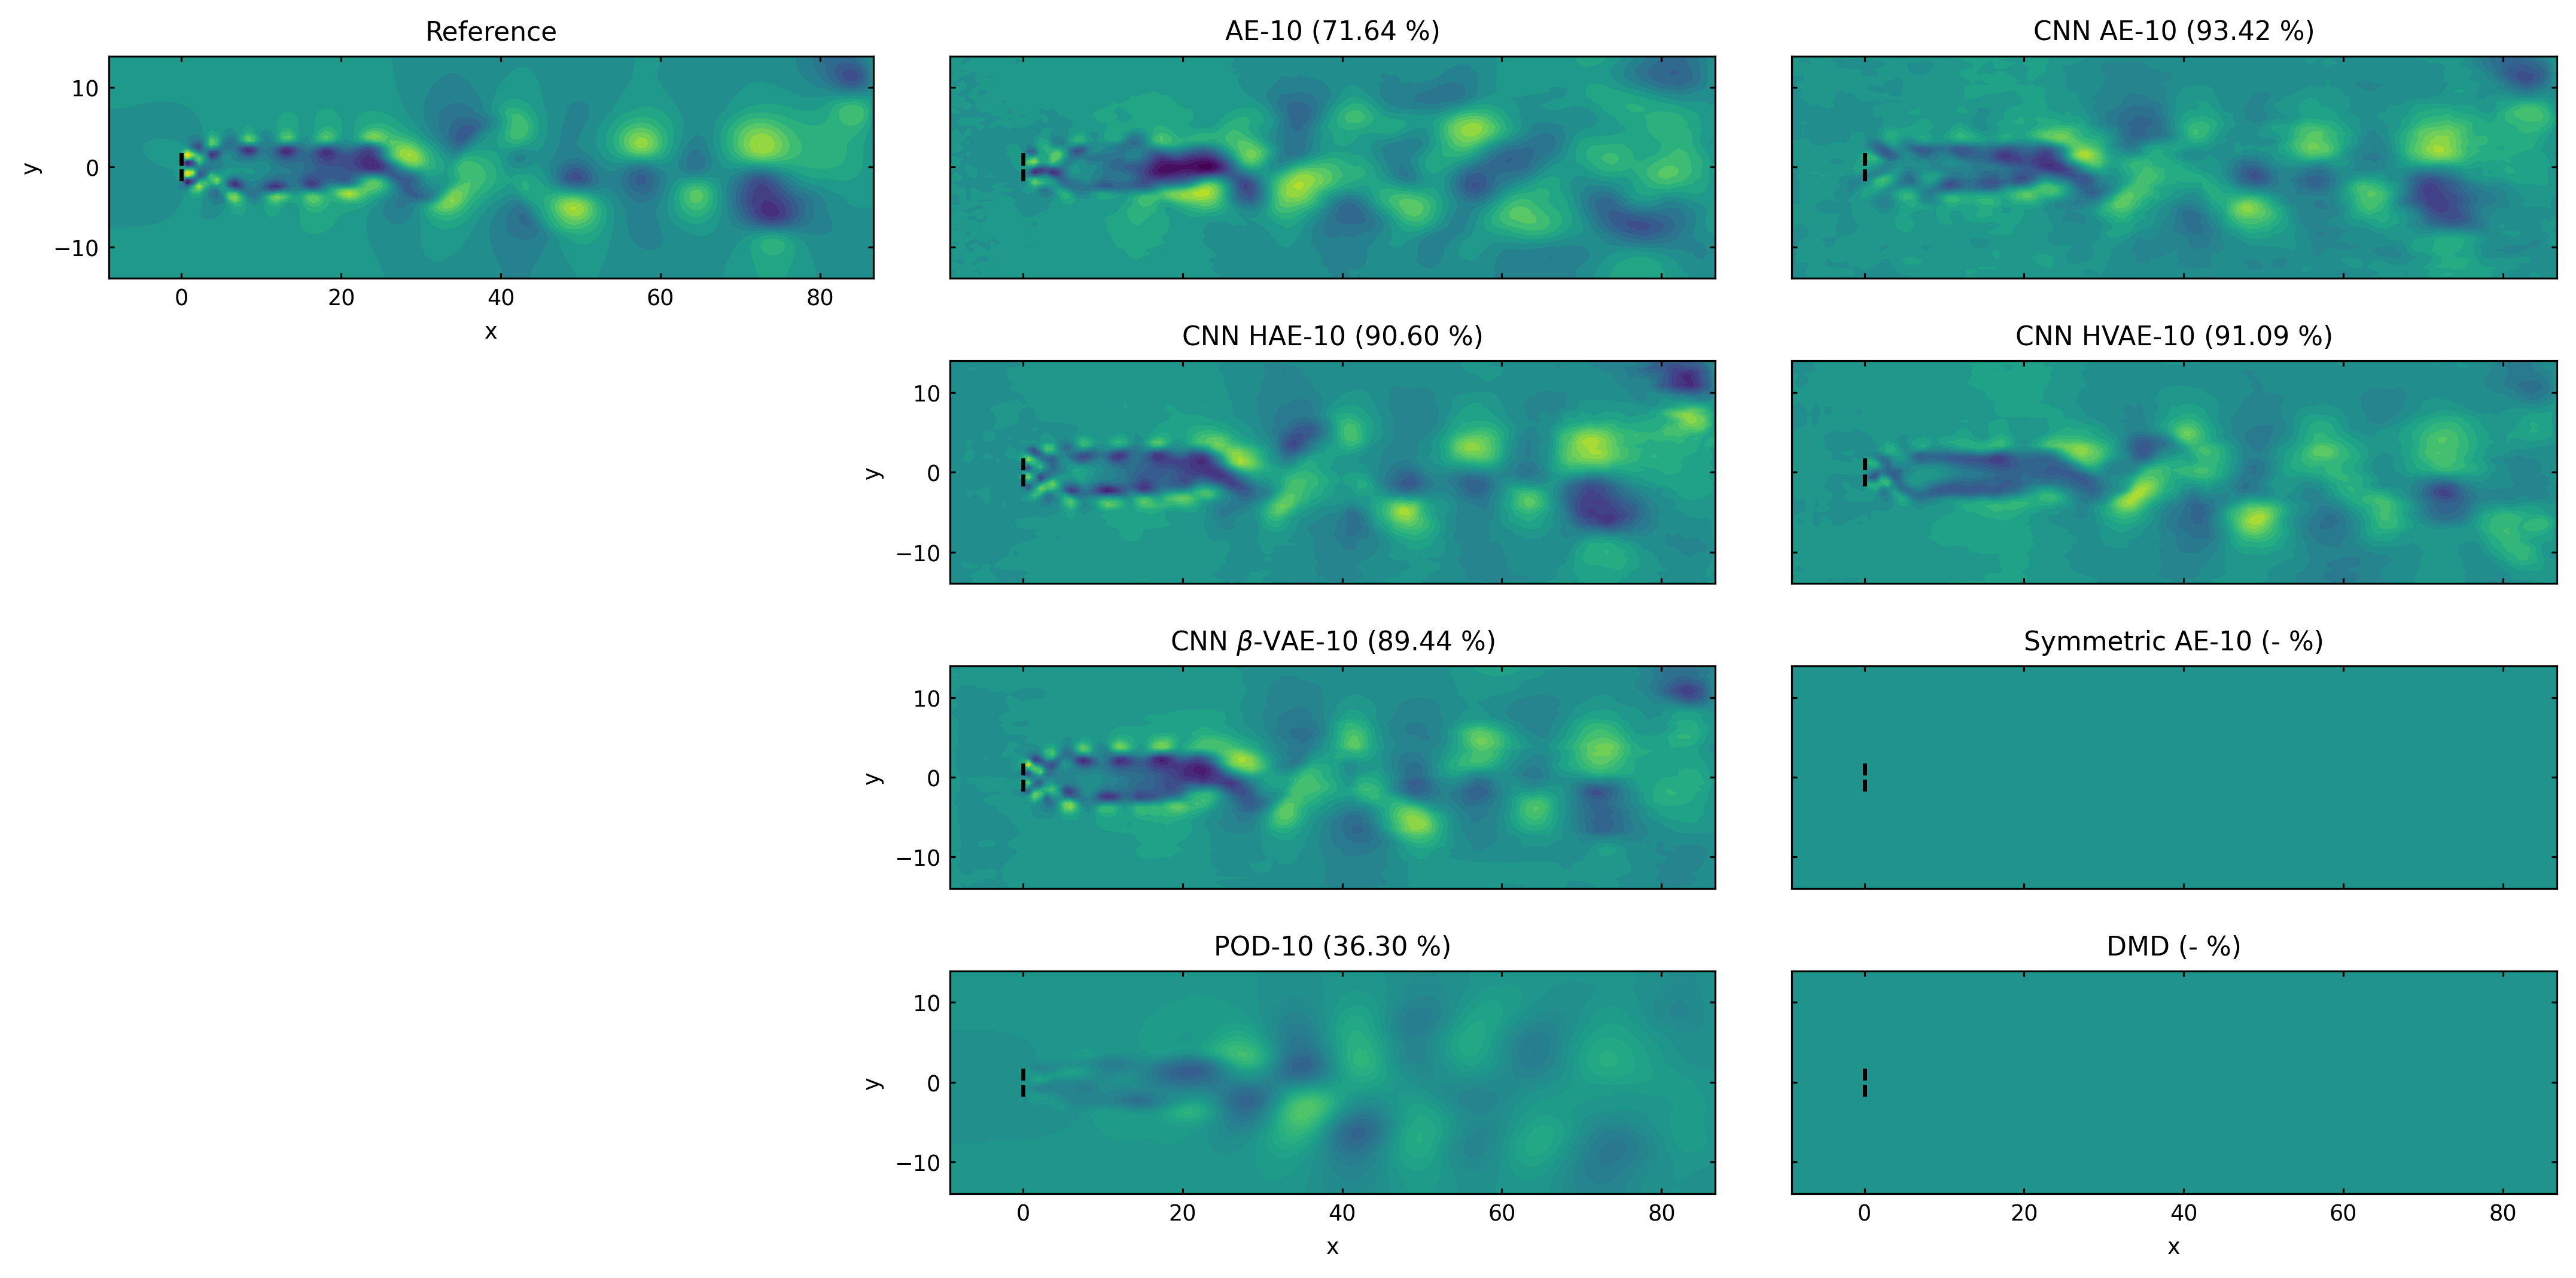

In [8]:
not_done_yet = np.zeros((1000, 128, 64, 2))

plotsAE.reconstruction(v_var, xx, yy,
                       v_rec_POD    = v_rec_POD,
                       v_rec_DMD    = not_done_yet,
                       v_rec_AE     = v_rec_AE,
                       v_rec_CNNAE  = v_rec_CNNAE,
                       v_rec_CNNHAE = v_rec_CNNHAE,
                       v_rec_HVAE   = v_rec_HVAE,
                       v_rec_SAE    = not_done_yet,
                       v_rec_VAE    = v_rec_VAE)

### Modes interpretability

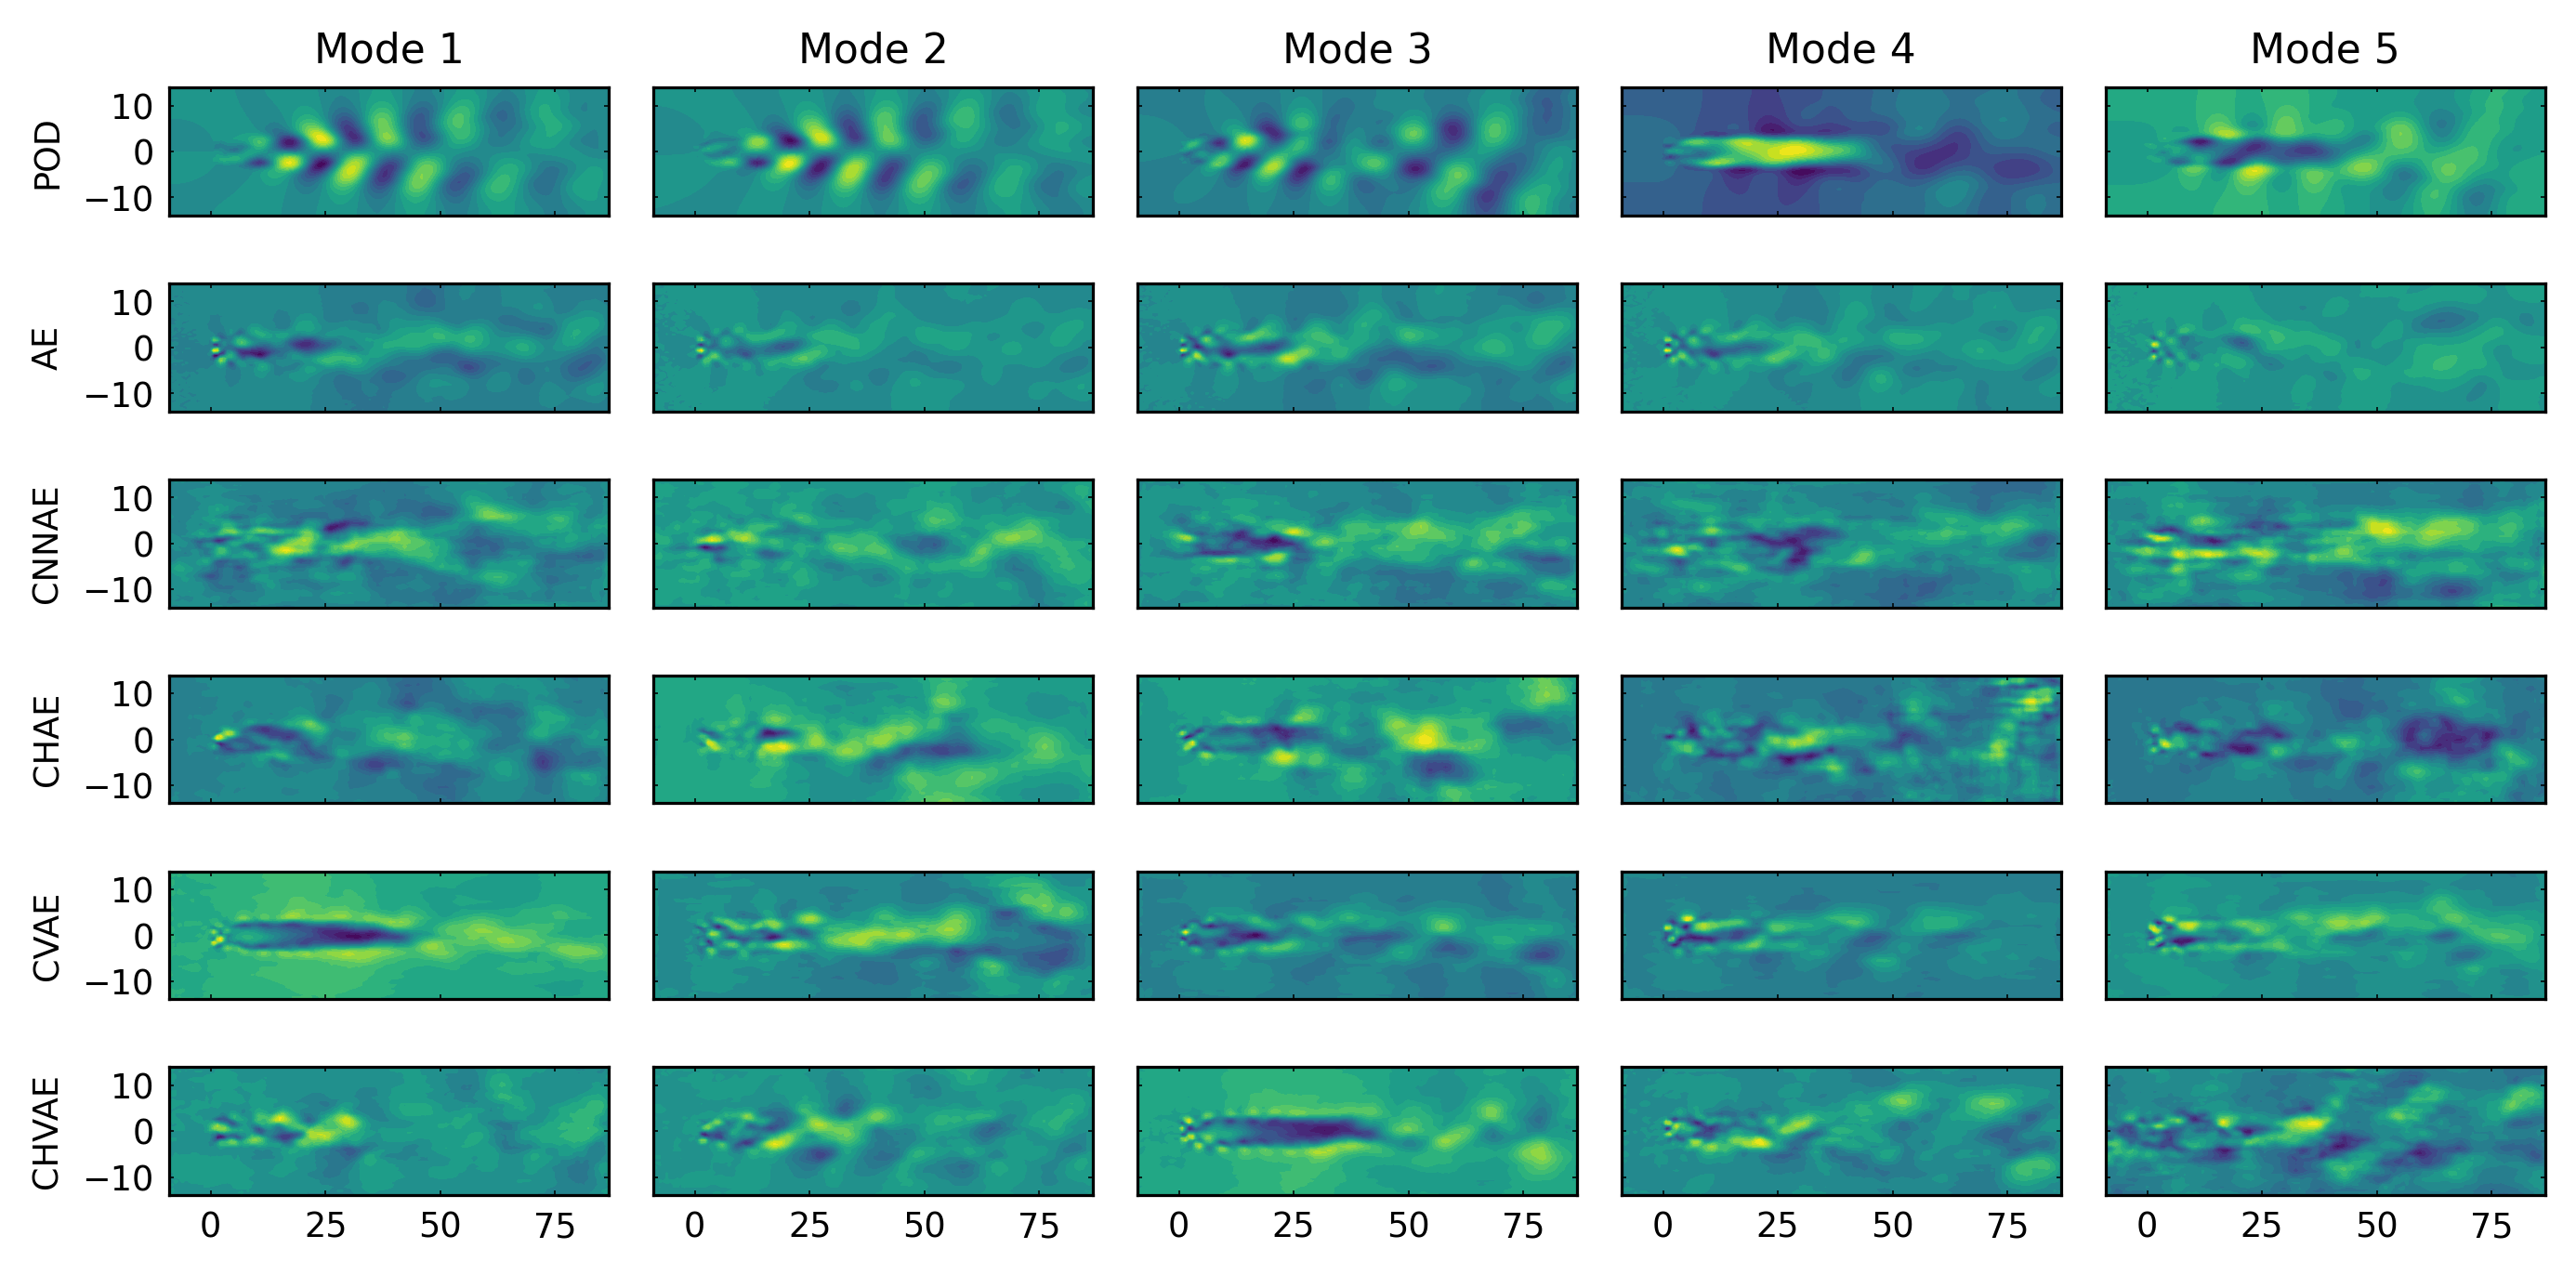

In [40]:
plt.rcParams.update({'font.size' : 8})
plt.rcParams['axes.linewidth'] = 0.7 #set the value globally

labels = ('POD', 'AE', 'CNNAE', 'CHAE', 'CVAE', 'CHVAE')

fig, ax = plt.subplots(6, 5, sharey = True, sharex = True, figsize = (10, 5), dpi = 330)

plt.set_cmap('viridis')

for ii in range(6):
  
  ax[ii, 0].set_ylabel(labels[ii])

  for jj in range(5):
    ax[ii,jj].contourf(xx, yy, modes[labels[ii]][str(jj+1)][-1, :, :, 0], levels = 20)
    
    ax[ii,jj].tick_params(direction= 'in', which= 'major', length= 1, bottom= True, top= True,
                          right= True, left=True, width = 0.35)

    ax[ii,jj].set_aspect('equal')

    # ax[5, jj].set_xlabel('x')
    ax[0, jj].set_title('Mode ' + str(jj + 1))

fig.subplots_adjust(wspace = 0.1, hspace = 0.1)

### Modes orthogonality

Text(0.5, 1.0, 'CNN $\\beta$-VAE (93.26 %)')

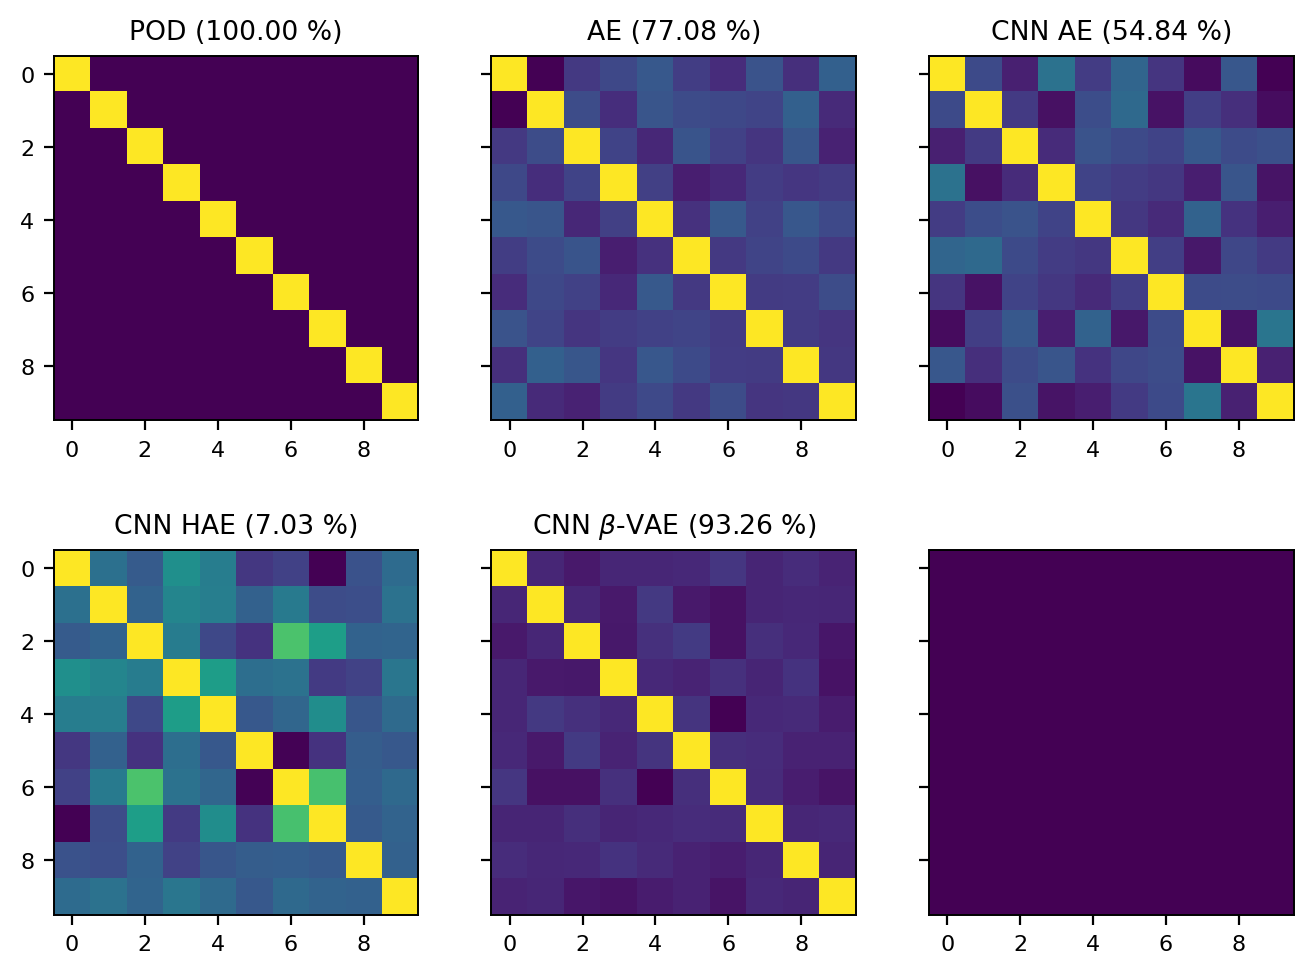

In [59]:
R_AE,    detR_AE    = libAE.correlation(LS_AE)
R_CNNAE, detR_CNNAE = libAE.correlation(LS_CNNAE)
R_CHAE,  detR_CHAE  = libAE.correlation(LS_CHAE)
R_CVAE,  detR_CVAE  = libAE.correlation(LS_VAE[2])
# R_CHVAE, detR_CHVAE = libAE.correlation(LS_CNNHVAE)

R_POD     = np.eye(10)
detR_POD  = 100

fig, ax = plt.subplots(2, 3, sharey = True, figsize = (8, 6), dpi = 200)

ax[0, 0].imshow(R_POD)
ax[0, 1].imshow(R_AE)
ax[0, 2].imshow(R_CNNAE)
ax[1, 0].imshow(R_CHAE)
ax[1, 1].imshow(R_CVAE)
ax[1, 2].imshow(R_CVAE * 0)

ax[0, 0].set_title('POD (%.2f %%)' %(detR_POD))
ax[0, 1].set_title('AE (%.2f %%)' %(detR_AE))
ax[0, 2].set_title('CNN AE (%.2f %%)' %(detR_CNNAE))
ax[1, 0].set_title('CNN HAE (%.2f %%)' %(detR_CHAE))
ax[1, 1].set_title(r'CNN $\beta$-VAE (%.2f %%)' %(detR_CVAE))
# ax[1, 2].set_title('CNN HVAE (%.2f %%)' %(detR_CHVAE))

